/var/folders/z9/0b_f0vqx7yz487m29qrdk82w0000gn/T/ipykernel_917/1713437098.py:36: RuntimeWarning: invalid value encountered in tan
  xptar = np.tan(ptarth)


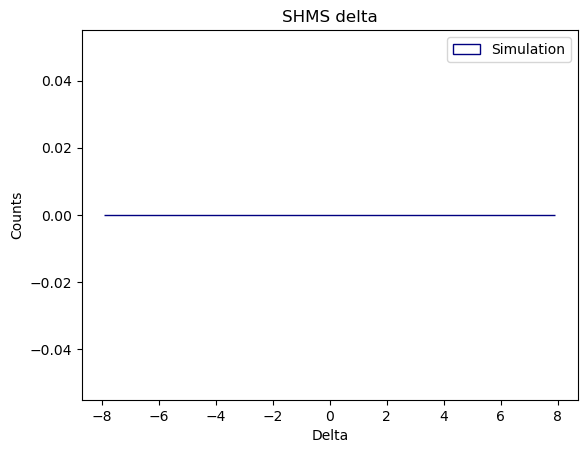

In [3]:
import scipy.interpolate
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy 

simroot = uproot.open("/Users/juliogutierrez/Downloads/hms_29p05deg_1p531_lh2_rsidis.root")
dataroot = uproot.open("/Users/juliogutierrez/Downloads/hms_coin_replay_production_24136_-1.root")
simtree = simroot["h10"]
tree = dataroot["T"]

psdelta = simtree["hsdelta"].array(library="np")
stop_id = simtree["stop_id"].array(library="np")
psytar = simtree["hsytar"].array(library="np")
psxptar = simtree["hsxptar"].array(library="np")
psyptar = simtree["hsyptar"].array(library="np")
sxpfp = simtree["hsxpfp"].array(library="np")
psypfp = simtree["hsypfp"].array(library="np")
sweights = simtree["weight"].array(library="np")

ptardp = tree["H.gtr.dp"].array(library="np")
xtar = tree["H.gtr.x"].array(library="np")
ytar = tree["H.gtr.y"].array(library="np")
ptarth = tree["H.gtr.th"].array(library="np")
ptarph = tree["H.gtr.ph"].array(library="np")
hmsCal = tree["H.cal.etottracknorm"].array(library="np")
xfp = tree["H.dc.x_fp"].array(library="np")
yfp = tree["H.dc.y_fp"].array(library="np")
xpfp = tree["H.dc.xp_fp"].array(library="np")
ypfp = tree["H.dc.yp_fp"].array(library="np")
Qtree = tree["H.kin.Q2"].array(library="np")

xptar = np.tan(ptarth)
yptar = np.tan(ptarph)

# Normalization parameters:

Ebeam = 8.565
p_spec = 1.531
delta_lo = -30
delta_hi = -30
e_min = p_spec * (1 + (0.01 * delta_lo))
e_max = p_spec * (1 + (0.01 * delta_hi))
phi_lo, theta_lo = -100, -100
phi_hi, theta_hi = 100, 100
A = 1
N_A = 6.022E23
Q_e = 1.602E-19
density = 0.07080 # g/cm^3
length = 10 #cm
thickness = density * length
charge = 10.486769 # mC
normfac = 6.4670859482710652

sim_charge = 1 # µC
# acc_charge = 90375.561
th_central = np.deg2rad(29.05) # rad 

deltaP = e_max - e_min
domega = (phi_hi - phi_lo)*(theta_hi - theta_lo) / (1000 * 1000)
lumin = (thickness) * (sim_charge / A) * (N_A / Q_e) * 1e-39


# cross_sec = 0.92044E-05
nentries = len(psdelta)
nentries_data = len(ptardp)

sim_error = 1 / np.sqrt(nentries)
data_error = 1 / np.sqrt(nentries_data)

df = pd.read_csv("/Users/juliogutierrez/Downloads/rctable.csv", delim_whitespace=True)
Eprime, theta, nu = np.empty(len(psdelta)), np.empty(len(psdelta)), np.empty(len(psdelta))

sig_rad = df["Sig_Rad_DIS"].to_numpy();

cuts_sim = (psdelta > -8) & (psdelta <8) & (stop_id==0) 
# & (hsxptar > -0.07) & (hsxptar < 0.07) & (hsyptar > -0.04) & (hsyptar < 0.07)


cuts_data = (ptardp > -8) & (ptardp < 8) & (hmsCal > 0.7) 
# & (xptar > -0.07) & (xptar < 0.07) & (yptar > -0.04) & (yptar < 0.07)

orig_parameters = df[["Eprime", "Theta"]].to_numpy()

interp = LinearNDInterpolator(orig_parameters, sig_rad)

cross_section, mc_scale = np.empty_like(psdelta), np.empty_like(psdelta)



for i in range(len(psdelta)):
    Eprime[i] = p_spec * (1 + (0.01 * psdelta[i]))
    theta[i] = np.rad2deg(np.arccos((np.cos(th_central) + psyptar[i] * np.sin(th_central)) / np.sqrt(1 + psxptar[i]**2 + psyptar[i]**2)))
    nu[i] = Ebeam - Eprime[i]
    cross_section[i] = interp(Eprime[i], theta[i])
    mc_scale[i] =  (cross_section[i] * lumin * domega * deltaP) / (sim_charge * nentries)


# bin_counts_eprime, bin_edges_eprime = np.histogram(Eprime,bins=100, range=(0,4))
# bin_centers_eprime = (bin_edges_eprime[1:] + bin_edges_eprime[:-1])/2


# bin_counts_theta, bin_edges_theta = np.histogram(theta,bins=100, range=(33,37))
# bin_centers_theta = (bin_edges_theta[1:] + bin_edges_theta[:-1])/2


# inter_parameters = np.column_stack((Eprime, theta))

# orig_eprime = df["Eprime"].to_numpy
# orig_theta = df["theta"].to_numpy





# print(cross_section)

bin_counts_delta, bin_edges_delta = np.histogram(ptardp[cuts_data],bins=100)
bin_counts_deltasim, bin_edges_deltasim = np.histogram(psdelta[cuts_sim], weights=mc_scale[cuts_sim], bins=100)


bin_centers = (bin_edges_delta[1:] + bin_edges_delta[:-1])/2
bin_centers_sim = (bin_edges_deltasim[1:] + bin_edges_deltasim[:-1])/2

# normalized_counts_deltasim = bin_counts_deltasim * mc_scale

# plt.hist(bin_centers, bins=len(bin_centers), histtype='step', weights=bin_counts_delta / charge, color='black', label="Data");
plt.hist(bin_centers_sim, bins=len(bin_centers_sim), histtype='step', weights=bin_counts_deltasim, linestyle='-', color='navy', label="Simulation");
plt.title("SHMS delta")
plt.xlabel("Delta")
plt.ylabel("Counts")
# plt.yscale('log')
plt.legend()
# plt.errorbar(bin_centers, bin_counts_delta, yerr=data_error, fmt='o');
# plt.errorbar(bin_centers_sim, bin_counts_deltasim, yerr=sim_error, fmt='o');
# plt.ylim(0,0.015)
